In [ ]:
!pip install opencv-python

In [1]:
import os
import cv2
import numpy as np

In [ ]:
video_path = '..\\data\\DataAnalysis\\video\\IMAG0006.avi'
output_folder = '..\\data\\DataAnalysis\\video\\output_frames'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [ ]:
cap = cv2.VideoCapture(video_path)

frame_count = 0
while True:
    ret, frame = cap.read()
    
    if not ret:
        break
        
    frame_filename = os.path.join(output_folder, f'frame_{frame_count:04d}.jpg')
    cv2.imwrite(frame_filename, frame)
    frame_count += 1
    
cap.release()
print('Video processing complete.')

In [ ]:
frame_count = 135

frames_folder = output_folder
frames = []

for i in range(frame_count):
    frame_path = os.path.join(frames_folder, f"frame_{i:04d}.jpg")
    frame = cv2.imread(frame_path)
    if frame is not None:
        frames.append(frame)

median_frame = np.median(np.array(frames), axis=0).astype(dtype=np.uint8)


### Median of Video

In [ ]:
import matplotlib.pyplot as plt
#cv2.imwrite('..\\data\\DataAnalysis\\video\\StatOutputs\\median_frame.jpg', median_frame)
plt.imshow(cv2.cvtColor(median_frame, cv2.COLOR_BGR2RGB))

### Color Histogram

In [ ]:
import matplotlib.pyplot as plt

num_bins = 256
frames_folder = output_folder

# Initialize accumulators for histograms
hist_accumulator = {
    'b': np.zeros((num_bins,), dtype=np.float64),
    'g': np.zeros((num_bins,), dtype=np.float64),
    'r': np.zeros((num_bins,), dtype=np.float64)
}

frame_count = 135
for i in range(frame_count):
    frame_path = os.path.join(frames_folder, f"frame_{i:04d}.jpg")
    frame = cv2.imread(frame_path)
    
    
    bc,gc,rc = cv2.split(frame)
    
    b_hist = cv2.calcHist([bc], [0], None, [num_bins], [0, 256])
    g_hist = cv2.calcHist([gc], [0], None, [num_bins], [0, 256])
    r_hist = cv2.calcHist([rc], [0], None, [num_bins], [0, 256])
    
    # normalization
    b_hist = b_hist / frame.size
    g_hist = g_hist / frame.size
    r_hist = r_hist / frame.size
    
    
    hist_accumulator['b'] += b_hist.flatten()
    hist_accumulator['g'] += g_hist.flatten()
    hist_accumulator['r'] += r_hist.flatten()

    
# Average the histograms over the number of frames
for color in hist_accumulator:
    hist_accumulator[color] /= frame_count



plt.figure(figsize=(15, 5))

for i, color in enumerate(['b', 'g', 'r']):
    plt.subplot(1, 3, i + 1)
    plt.plot(hist_accumulator[color], color=color)
    plt.xlim([0, num_bins])
    plt.title(f'{color.upper()} Channel Histogram')

- The distribution of colors is not uniform. There are significant variations in the lower to mid-range intensity values, especially in the green channel. This indicates that different frames or regions within frames have varying color intensities.


- We can also tell that the video contains scenes with high brightness, leading to many pixels being close to the maximum intensity value of 255. I.e the video is overexposed.


- We can see that the Green channel has higher low intensity values compared to the other channels. This indicates that the video has a higher proportion of green pixels with low intensity values compared to the other channels. This makes sense as the video is shot outdoors, where the green color of the grass and trees is prevalent. 


### Calcuate Variance, Mean Difference and Standard Deviation of the Video



In [ ]:
video_path = '..\\data\\DataAnalysis\\video\\IMAG0006.avi'

cap = cv2.VideoCapture(video_path)

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

cap.release()


variance_accumulator = np.zeros((frame_height, frame_width), dtype=np.float64)
prev_frame = None
frame_diffs = []

for i in range(frame_count):
    frame_path = os.path.join(frames_folder, f"frame_{i:04d}.jpg")
    frame = cv2.imread(frame_path)
    
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    if prev_frame is not None:
        frame_diff = cv2.absdiff(gray_frame, prev_frame)
        frame_diffs.append(frame_diff)
    
    variance_accumulator += (gray_frame.astype(np.float64) - variance_accumulator / (i + 1)) ** 2
    prev_frame = gray_frame
    
# mean and variance of frame differences
mean_diff = np.mean(frame_diffs,axis=0)    
var_diff = np.var(frame_diffs,axis=0)    


# Compute final variance
variance = variance_accumulator / frame_count

# Normalize variance to range [0, 255] and convert to uint8
variance_normalized = cv2.normalize(variance, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
output_dir = '..\\data\\DataAnalysis\\video\\VideoAnalysisResults'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


# cv2.imwrite(os.path.join(output_dir, 'mean_diff.jpg'), mean_diff.astype(np.uint8))
# cv2.imwrite(os.path.join(output_dir, 'var_diff.jpg'), var_diff.astype(np.uint8))
# cv2.imwrite(os.path.join(output_dir, 'variance.jpg'), variance.astype(np.uint8))

In [ ]:
# Variance Difference
plt.imshow(var_diff, cmap='hot')
plt.title('Variance Difference')


We can clearly see much higher variances in the center and left part of the image, compared to the right part. This is due to the fact that on the right side is the beehive, which is not moving, while the left side is the entrance of the beehive, where the bees are constantly moving in and out. This movement causes the variance to be higher in this area. Additionally, in the top a lot of the variance is due to the branches of the tree moving in the wind.

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(mean_diff, cmap='hot')
plt.title('Mean Difference')

In [ ]:

## Laplacian Variance - checking how smooth the video is
laplacian_vars = []

for i in range(frame_count):
    frame_path = os.path.join(frames_folder, f"frame_{i:04d}.jpg")
    frame = cv2.imread(frame_path)
    
    laplacian_var = cv2.Laplacian(frame, cv2.CV_64F).var()
    laplacian_vars.append(laplacian_var)
    #print(f'Frame {i}: Laplacian variance: {laplacian_var}')    

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(len(laplacian_vars)), laplacian_vars, label='Laplacian Variance')
plt.xlabel('Frame Index')
plt.ylabel('Variance')
plt.title('Laplacian Variance - Checking Video Smoothness')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print('Mean Laplacian Variance:', np.mean(laplacian_vars))

#### Pipeline to extract all of this Data Analysis Info Given a Video

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def extract_frame_diff(frame, prev_frame):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_diff = cv2.absdiff(gray_frame, prev_frame)

    return frame_diff,gray_frame

def extract_laplacian(frame):
    laplacian_var = cv2.Laplacian(frame, cv2.CV_64F).var()
    return laplacian_var


def extract_frames(title, video_path, output_folder):
    cap = cv2.VideoCapture(video_path)

    frame_count = 0
    while True:
        ret, frame = cap.read()
        
        if not ret:
            break
        
        output_folder_path = output_folder + title
        if not os.path.exists(output_folder_path):
            os.makedirs(output_folder_path)
        frame_filename = os.path.join(output_folder_path, f'frame_{frame_count:04d}.jpg')
        cv2.imwrite(frame_filename, frame)
        frame_count += 1
        
    cap.release()
    print('Video processing complete.')



def median_frame(frames):
    median_frame = np.median(np.array(frames), axis=0).astype(dtype=np.uint8)
    return median_frame



def extract_color_histogram(hist_accumulator, frame, num_bins=256):
    bc, gc, rc = cv2.split(frame)
    
    b_hist = cv2.calcHist([bc], [0], None, [num_bins], [0, 256])
    g_hist = cv2.calcHist([gc], [0], None, [num_bins], [0, 256])
    r_hist = cv2.calcHist([rc], [0], None, [num_bins], [0, 256])
    
    # normalization
    b_hist = b_hist / frame.size
    g_hist = g_hist / frame.size
    r_hist = r_hist / frame.size
    
    hist_accumulator['b'] += b_hist.flatten()
    hist_accumulator['g'] += g_hist.flatten()
    hist_accumulator['r'] += r_hist.flatten()
    




def analyze_frame(frame,prev_frame,num_bins,laplacian_vars,hist_accumulator,frame_diffs,frames):
   extract_color_histogram(hist_accumulator, frame, num_bins=num_bins)
   laplacian_vars.append(extract_laplacian(frame))
    
   if prev_frame is not None:
        frame_diff, gray_frame = extract_frame_diff(frame, prev_frame)
        frame_diffs.append(frame_diff)
        prev_frame = gray_frame
   else:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        prev_frame = gray_frame
    
   frames.append(frame)
   
   return prev_frame



def iterate_frames(video_path, num_bins=256,frame_limit=1000):
    prev_frame = None
    frames = []
    frame_diffs = []
    laplacian_vars = []

    hist_accumulator = {
        'b': np.zeros((num_bins,), dtype=np.float64),
        'g': np.zeros((num_bins,), dtype=np.float64),
        'r': np.zeros((num_bins,), dtype=np.float64)
    }
    
    cap = cv2.VideoCapture(video_path)
    frame_size = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        
        if not ret:
            break
        
        prev_frame = analyze_frame(frame,prev_frame,num_bins,laplacian_vars,hist_accumulator,frame_diffs,frames)
        frame_count += 1
        
        
        if (frame_count+1)%50 == 0:
            print(f'Appended {(frame_count+1)}/{frame_size} frames..')
            
        if frame_count == frame_limit:
            break    
        

    cap.release()
    
    
    print(f'Number of appended frames: {len(frames)}')
    mean_diff = np.mean(frame_diffs, axis=0)    
    var_diff = np.var(frame_diffs, axis=0)    
    median_frame = np.median(np.array(frames), axis=0).astype(dtype=np.uint8)
    
    
    return  hist_accumulator, laplacian_vars, var_diff, mean_diff, frame_count, median_frame

def plot_and_save_laplacian_variance(laplacian_vars,save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(laplacian_vars)), laplacian_vars, label='Laplacian Variance')
    plt.xlabel('Frame Index')
    plt.ylabel('Variance')
    plt.title('Laplacian Variance - Checking Video Smoothness')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

def plot_and_save_histograms(hist_accumulator, frame_count,output_path=None,num_bins=256):
    # Average the histograms over the number of frames
    for color in hist_accumulator:
        hist_accumulator[color] /= frame_count
    
    plt.figure(figsize=(15, 5))
    
    for i, color in enumerate(['b', 'g', 'r']):
        plt.subplot(1, 3, i + 1)
        plt.plot(hist_accumulator[color], color=color)
        plt.xlim([0, num_bins])
        plt.title(f'{color.upper()} Channel Histogram')
        plt.savefig(f'{output_path}/color_histogram.jpg')

        
    plt.tight_layout()

    plt.show()

def plot_variance_difference(var_diff):
    plt.figure(figsize=(10, 6))
    plt.imshow(var_diff, cmap='hot')
    plt.title('Variance Difference')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

def plot_mean_difference(mean_diff):
    plt.figure(figsize=(10, 6))
    plt.imshow(mean_diff, cmap='hot')
    plt.title('Mean Difference')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

def plot_median_frame(median_frame):
    plt.figure(figsize=(10, 6))
    plt.imshow(median_frame)
    plt.title('Median Frame')
    plt.tight_layout()
    plt.show()

def plot_results(output_dir,laplacian_vars, hist_accumulator, var_diff, mean_diff, frame_count,median_frame,num_bins=256):
    plot_variance_difference(var_diff)
    plot_mean_difference(mean_diff)
    plot_median_frame(median_frame)
    plot_and_save_laplacian_variance(laplacian_vars,save_path=os.path.join(output_dir, 'laplacian_variance.jpg'))
    plot_and_save_histograms(hist_accumulator, frame_count,output_path=output_dir,num_bins=256)
    
    print('Mean Laplacian Variance:', np.mean(laplacian_vars))
    
    return hist_accumulator, laplacian_vars

def write_results_to_file(output_dir, mean_diff, var_diff,median_frame,hist_accumulator,frame_count,laplacian_vars):
    cv2.imwrite(os.path.join(output_dir, 'mean_diff.jpg'), mean_diff.astype(np.uint8))
    cv2.imwrite(os.path.join(output_dir, 'var_diff.jpg'), var_diff.astype(np.uint8))
    cv2.imwrite(os.path.join(output_dir, 'median_frame.jpg'), median_frame)    


def analyze_video(video_path, output_folder,title,frame_limit = 1000):
    num_bins = 256
    output_path = output_folder + '_' + title
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    
    hist_accumulator,laplacian_vars,var_diff,mean_diff,frame_count,median_frame = iterate_frames(video_path,num_bins,frame_limit)
    
    
    plot_results(output_path,laplacian_vars, hist_accumulator, var_diff, mean_diff, frame_count, median_frame, num_bins=num_bins)
    write_results_to_file(output_path, mean_diff, var_diff,median_frame,hist_accumulator,frame_count,laplacian_vars)

Appended 50/162 frames..
Appended 100/162 frames..
Number of appended frames: 136


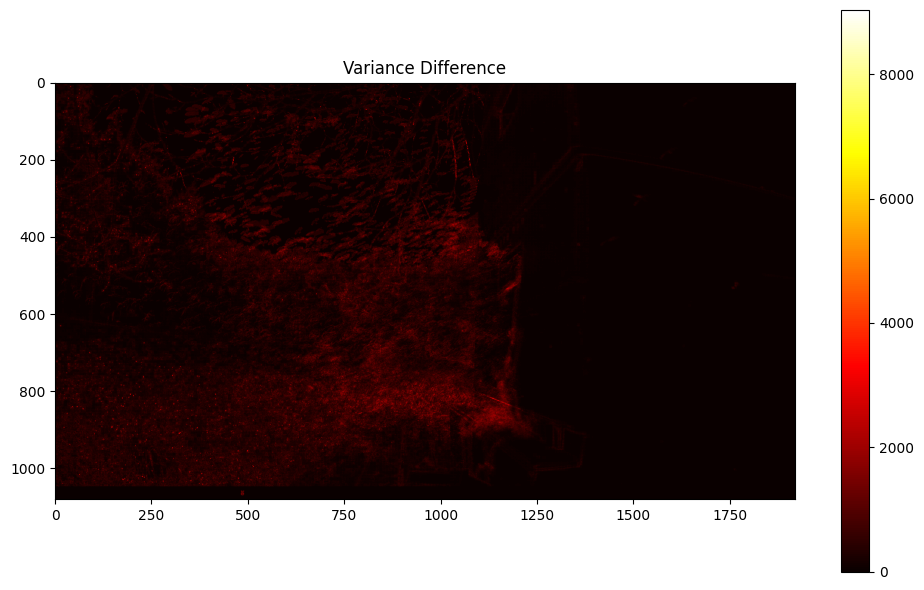

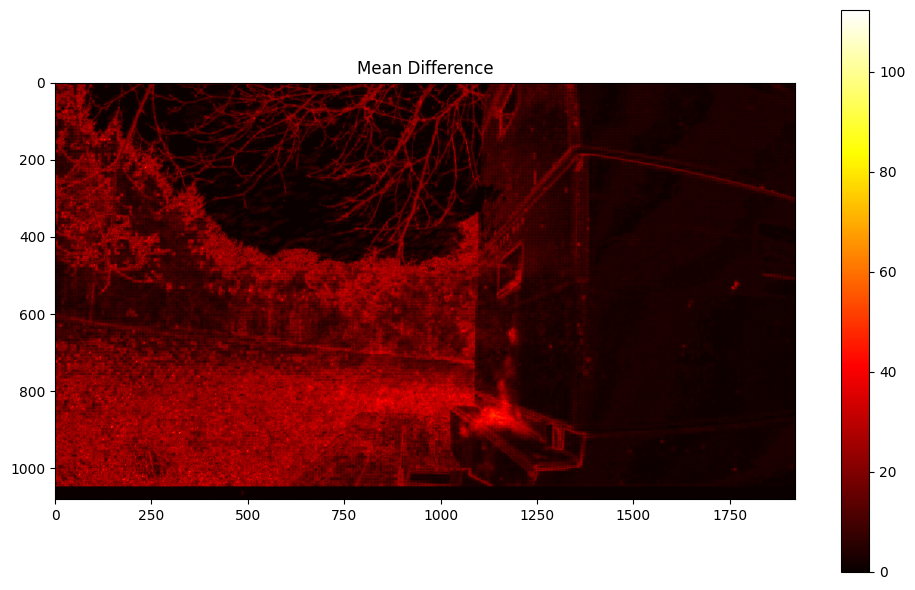

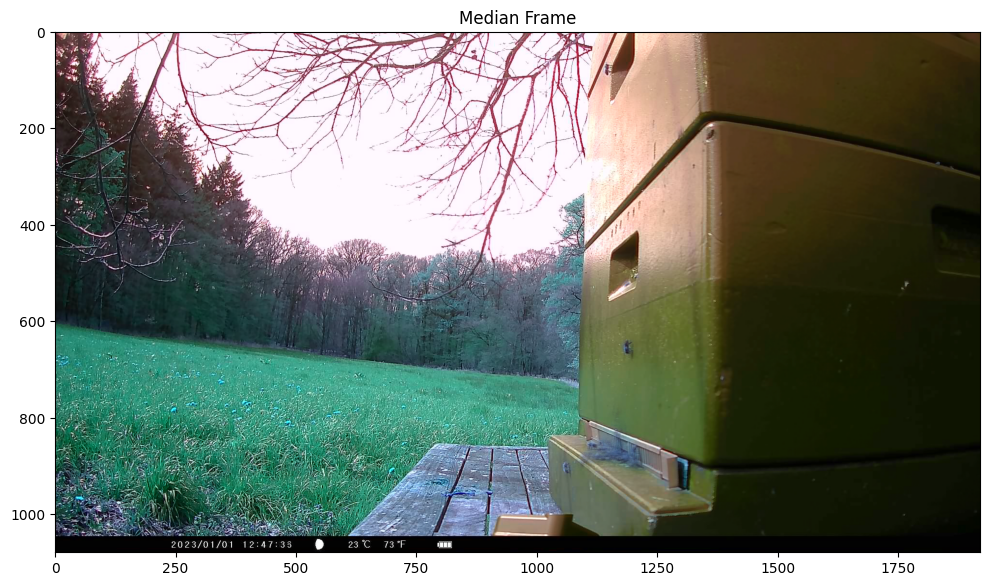

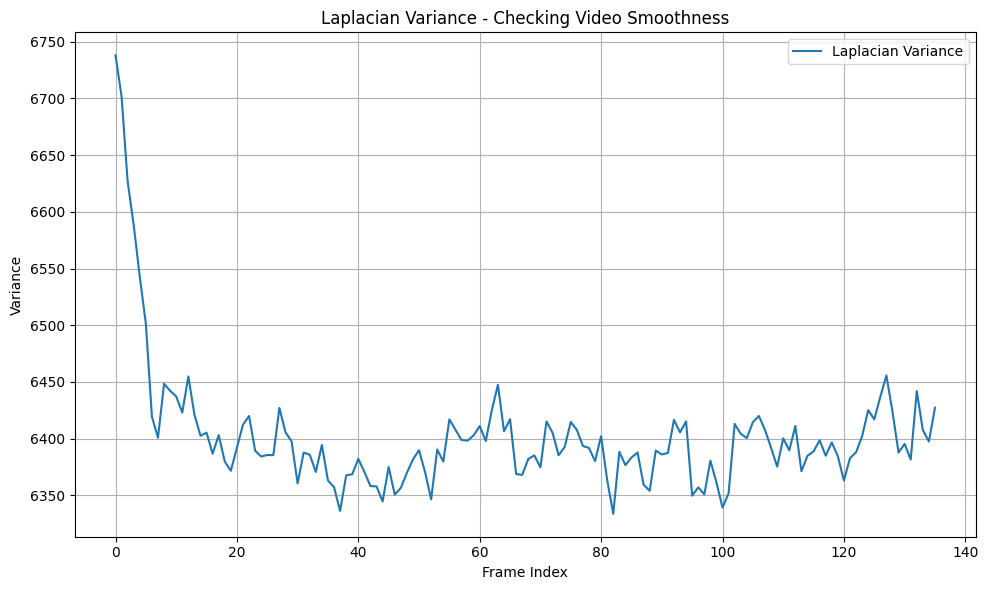

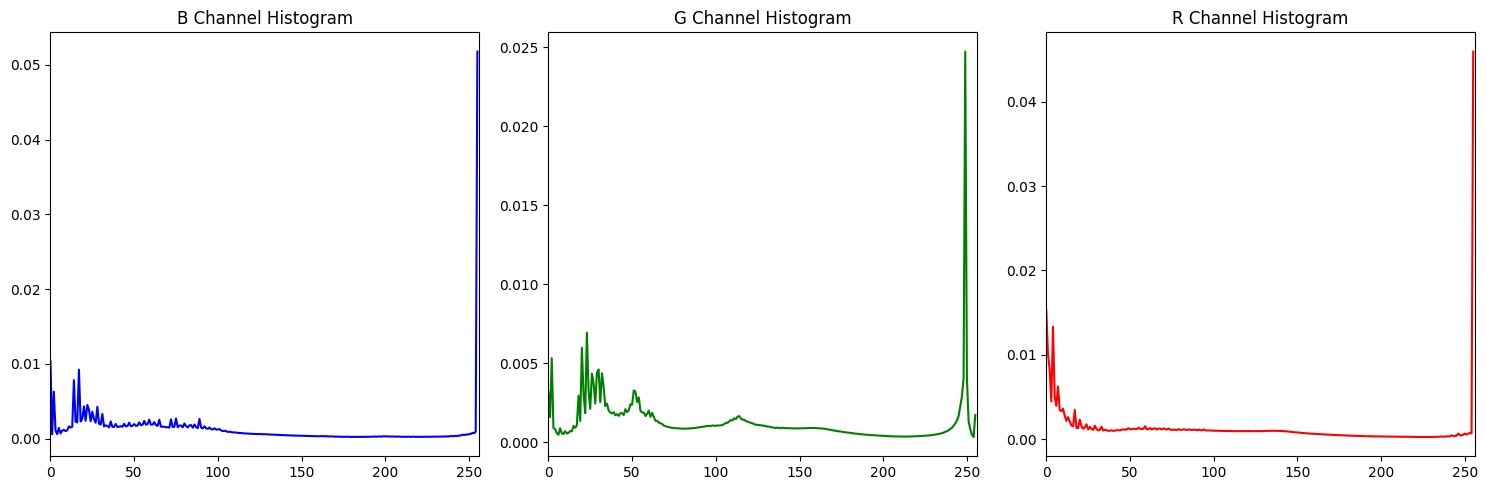

Mean Laplacian Variance: 6401.6579928310075


In [7]:
video_path = '..\\data\\DataAnalysis\\video_beehive1_day\\IMAG0006.avi'
output_folder = '..\\data\\DataAnalysis\\video_beehive1_day\\output'
title = 'video_beehive1_day'

analyze_video(video_path, output_folder,title,frame_limit=200)

Appended 50/161 frames..
Appended 100/161 frames..
Number of appended frames: 135


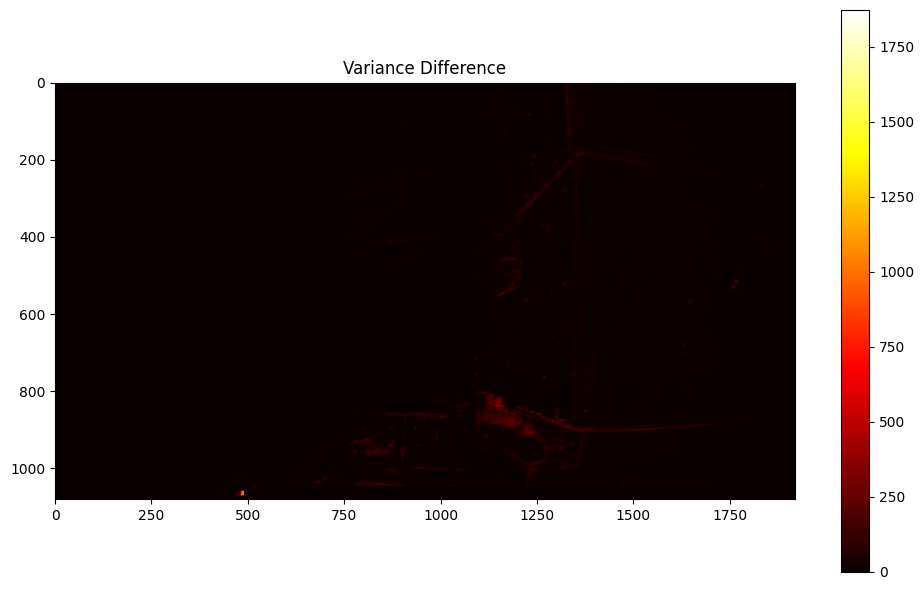

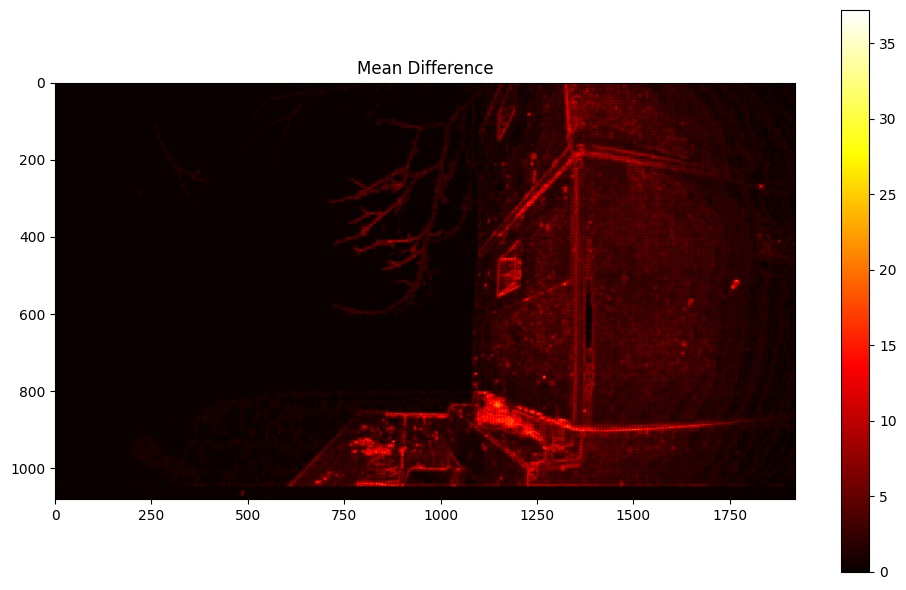

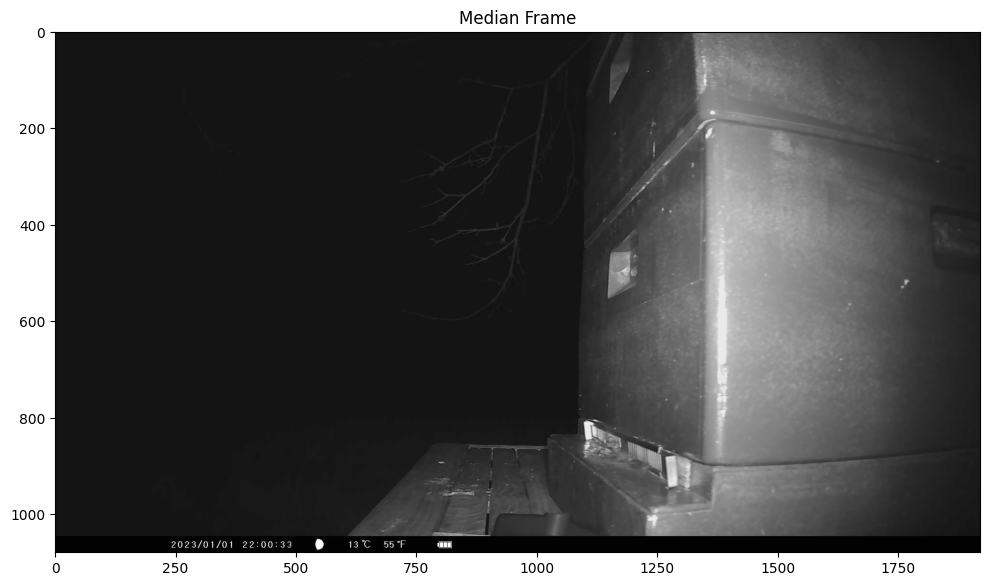

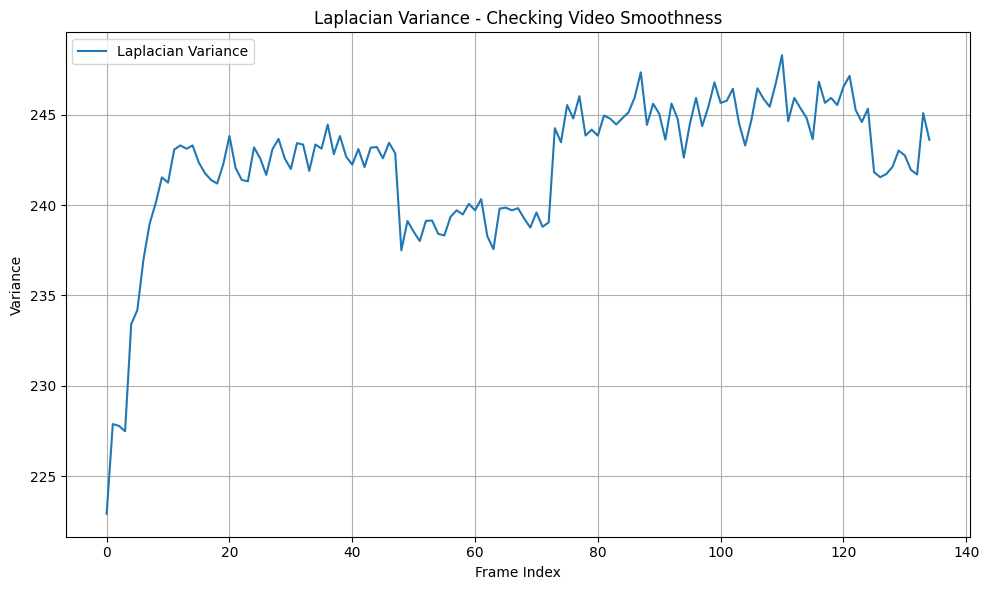

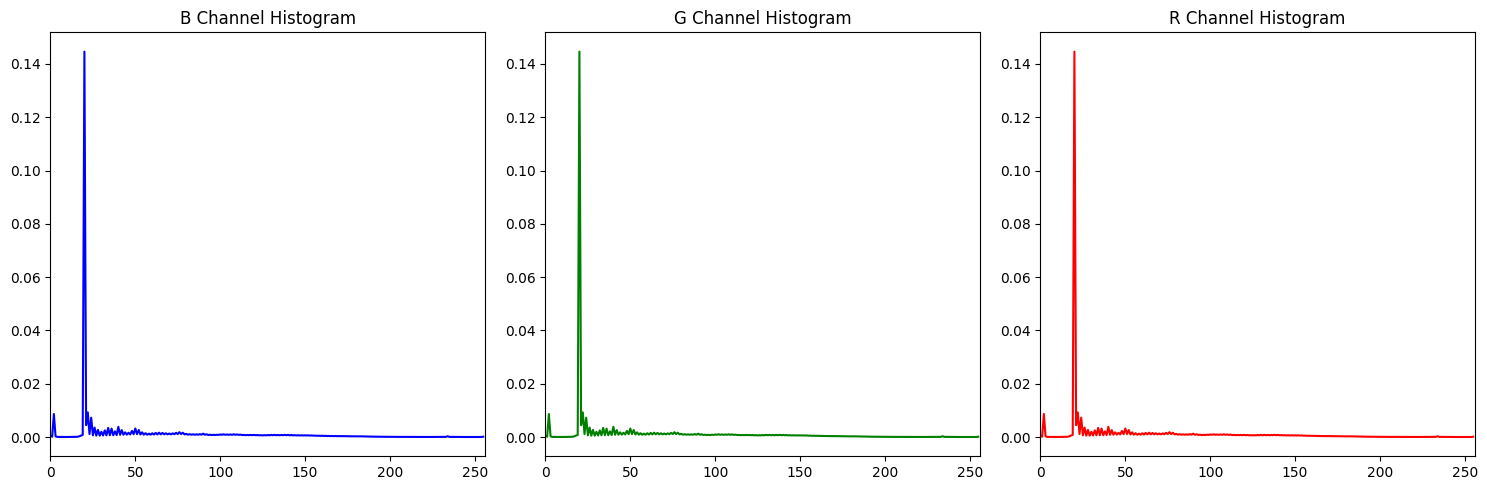

Mean Laplacian Variance: 242.28680879712962


In [5]:
## behive 1 night

video_path = '..\\data\\DataAnalysis\\video_beehive1_night\\IMAG0058.avi'
output_folder = '..\\data\\DataAnalysis\\video_beehive1_night\\output'
title = 'video_beehive1_night'
analyze_video(video_path, output_folder,title)

Appended 50/5408 frames..
Appended 100/5408 frames..
Appended 150/5408 frames..
Appended 200/5408 frames..
Number of appended frames: 200


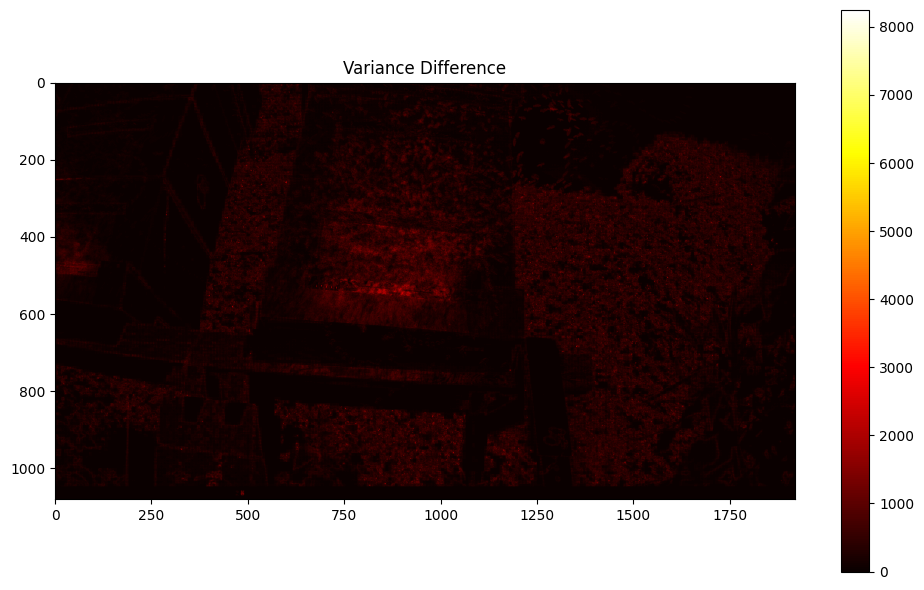

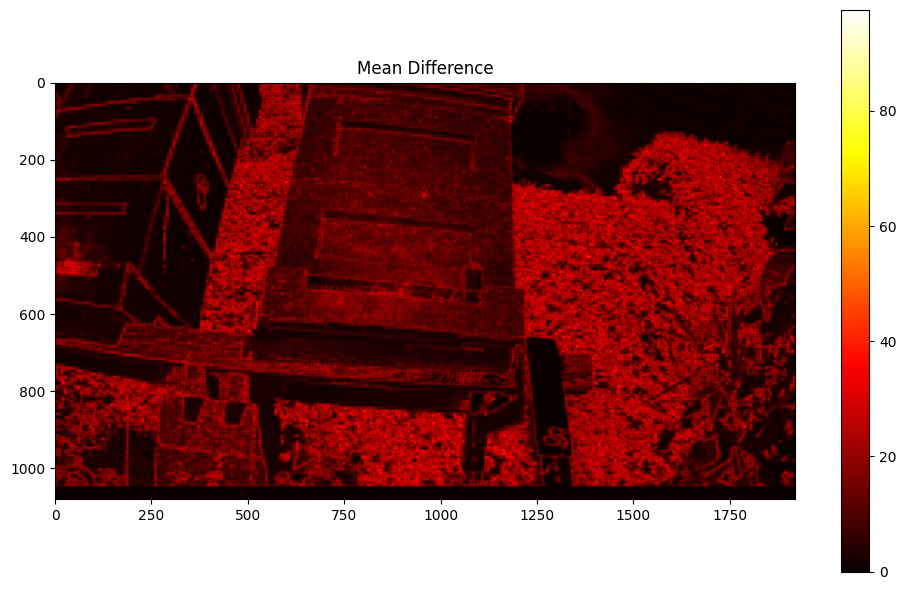

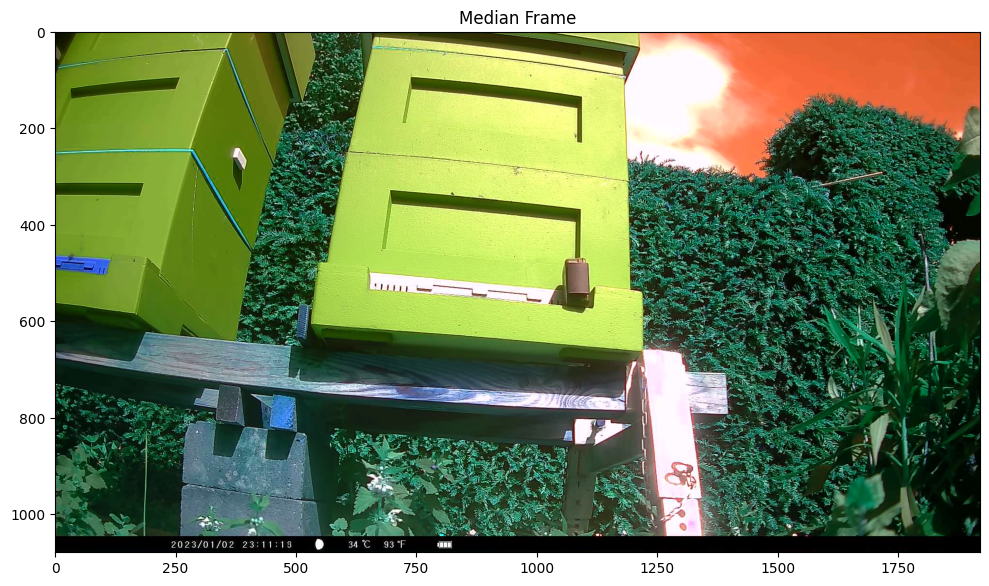

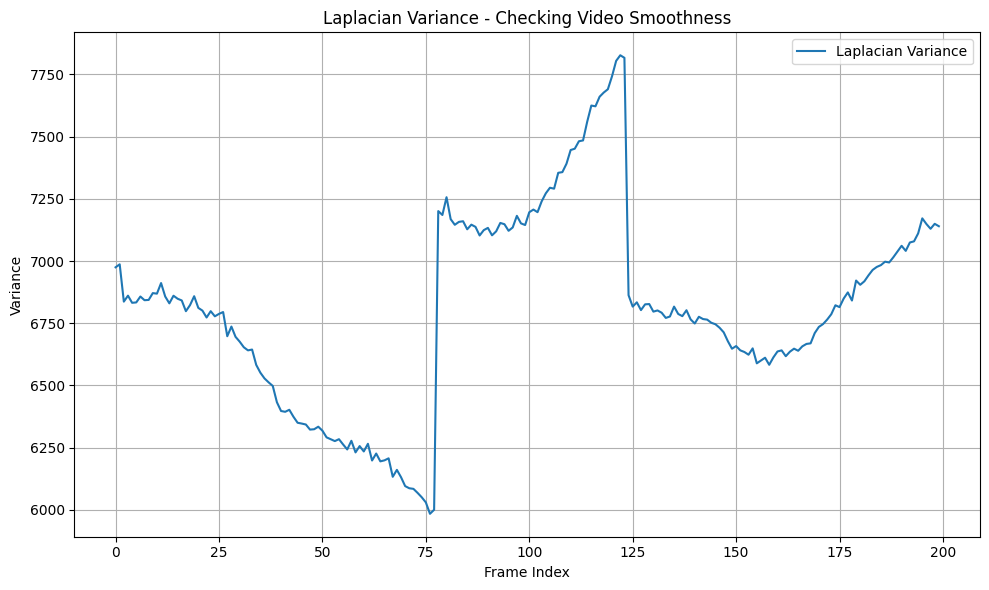

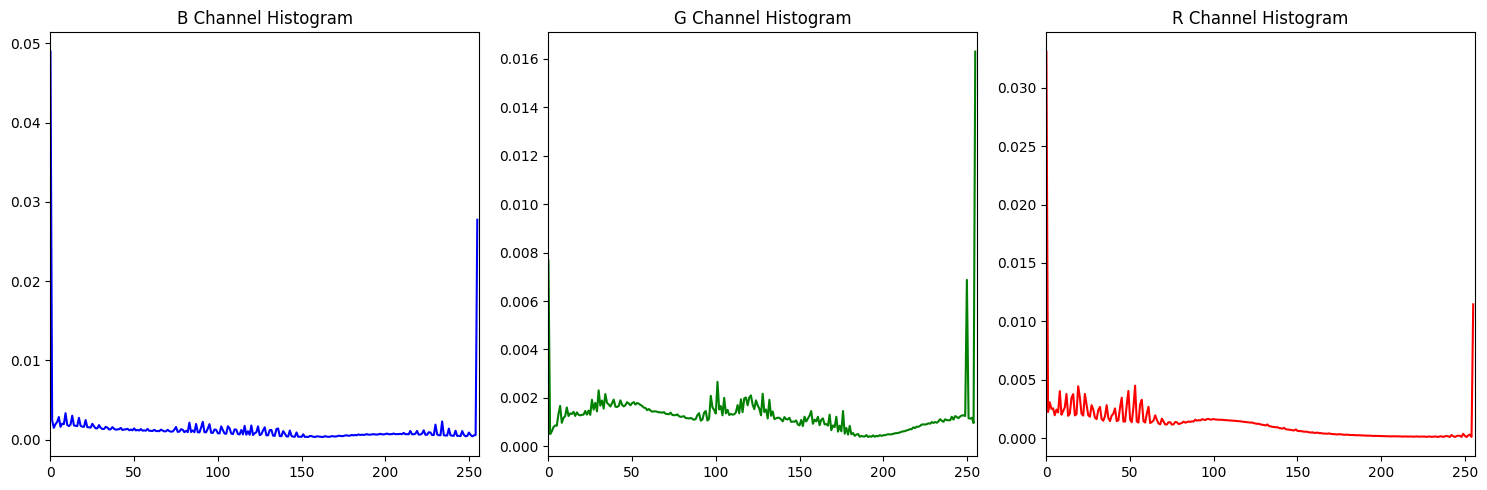

Mean Laplacian Variance: 6811.057506679205


In [9]:
video_path = '..\\data\\DataAnalysis\\video_beehive2_long_day\\IMAG0016.avi'
output_folder = '..\\data\\DataAnalysis\\video_beehive2_long_day\\output'
title = 'video_beehive2_long_day'
analyze_video(video_path, output_folder,title,frame_limit=200)